# Safe Decision Tree Notebook 
### First set some path variables: this notebook expects to find the repository root in your home directory. You can change this by editing the last sys.path.append line to reflect with the repository root is found on your system

In [ ]:
import sys
import os

from os.path import expanduser

ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("")))
sys.path.append(ROOT_DIR)
home = expanduser("~")
sys.path.append(os.path.abspath(home + "/AI-SDC"))

## Some basic examples to explore what the wrapper class could look like and be implemented

### Lets start by making some data with one disclosive case
- We'll do this by adding an example to the iris data and give it a new class to make things really obvious.
- The same risks exist for more complex data sets but _everyone knows iris_

In [2]:
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target


# print the max and min values in each feature to help hand-craft the disclosive point
for feature in range(4):
    print(f"feature {feature} min {np.min(X[:,feature])}, min {np.max(X[:,feature])}")

# now add a single disclosve point with features [7,2,4.5,1] and label 3
X = np.vstack([X, (7, 2.0, 4.5, 1)])
y = np.append(y, 4)

feature 0 min 4.3, min 7.9
feature 1 min 2.0, min 4.4
feature 2 min 1.0, min 6.9
feature 3 min 0.1, min 2.5


### and import some basic libraries to show our point

In [3]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

## Here's the raw version
-  note I am setting random_state=1 to make it deterministic, just so you get the same reults as me
 - the general point is not that someone always will, but that they could
 - in practice I ran 10 times not setting random state and got the same tree 4/5 times

Training set accuracy in this naive case is 1.0


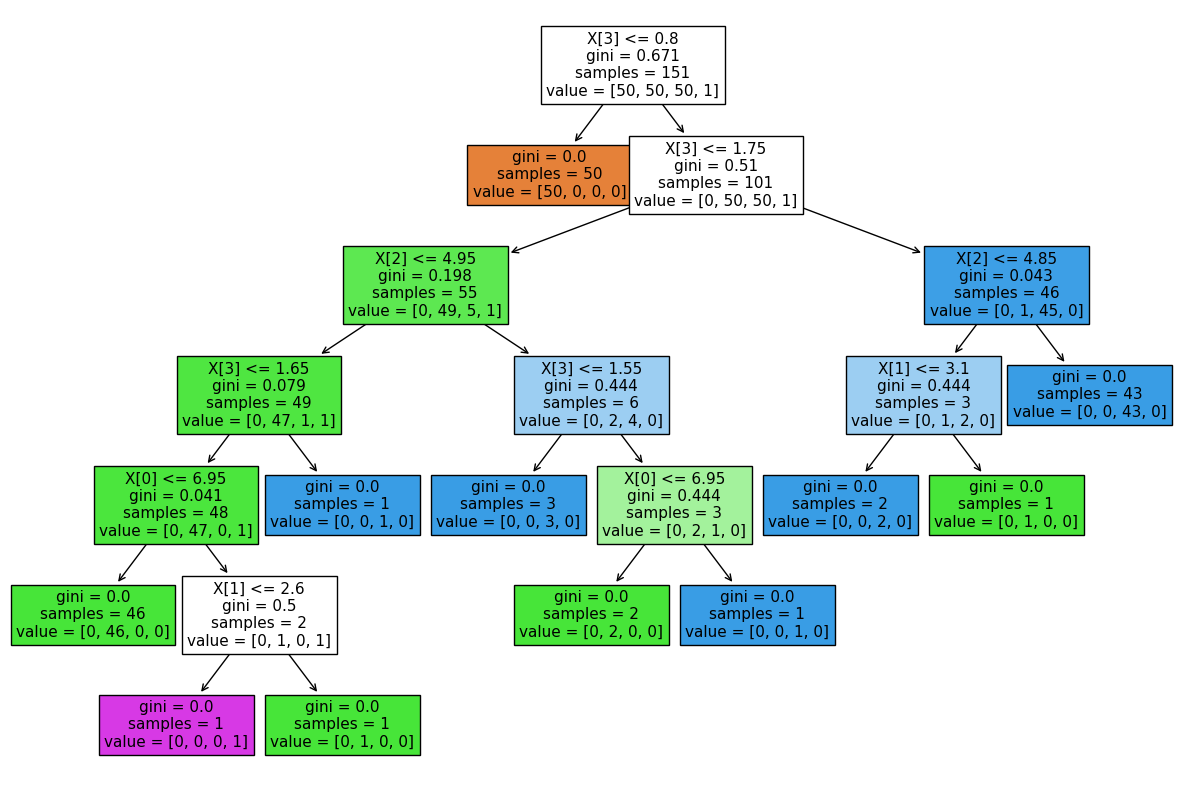

In [4]:
# example code with no safety

from sklearn.tree import DecisionTreeClassifier

rawDT = DecisionTreeClassifier(min_samples_leaf=1, criterion="gini", random_state=1)
rawDT.fit(X, y)

print(f"Training set accuracy in this naive case is {rawDT.score(X,y)}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(rawDT, filled=True, ax=ax, fontsize=11)

### As we can see we have several disclosive nodes, one of which is our added point (in purple)
The exact values cannot be inferred but if we (reasonably) assume all features are non-negative we can get uper and lower bounds for the attribute values on that node:  
> (6.95,inf),  \[0,2.6\],  (0,4.95\],  (0.8, 1.65\]

so this is disclosive to a certain degree.

- In this case I spent 5 minutes manually tuning the values of the added point so that the tree included at least one decision node for each feature

- It would be fairly trivial to use something like a Genetic Algorithm to automatically tune the feature values of the added point minimising the difference between the upper and lower bounds for each feature.

- But that is not really the point of this exercise which was to show that allowing the user to set inappropriate values for a single parameter could produce a disclosive tree. 


### Diligent user realises problem, and changes their code to enforce at least n samples in each leaf
We'll use n=5 

Training set accuracy with threshold rule enforced is 0.9668874172185431


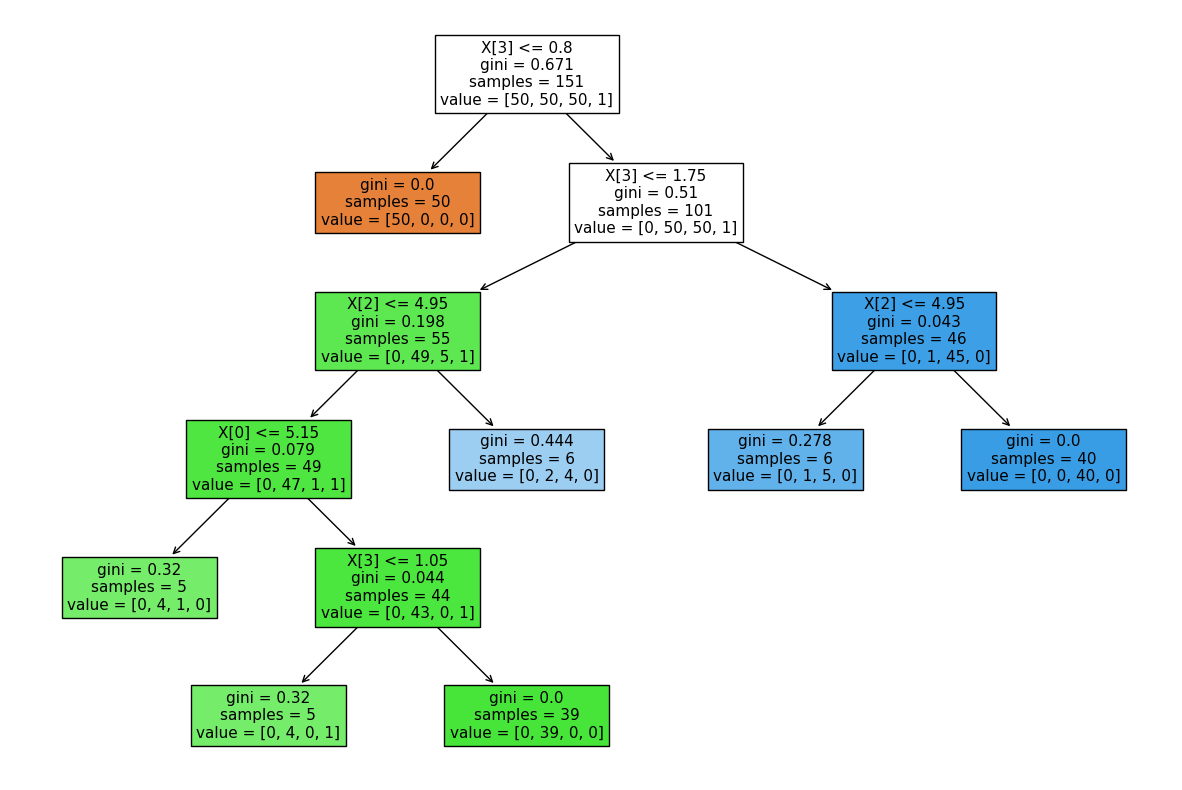

In [5]:
manualDT = DecisionTreeClassifier(min_samples_leaf=5, random_state=1)
manualDT.fit(X, y)

print(f"Training set accuracy with threshold rule enforced is {manualDT.score(X,y)}")

fig2, ax2 = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(manualDT, filled=True, ax=ax2, fontsize=11)

### output is now non-disclosive (at least according to the threshold rule)
- You can easily see we don't get a node for the new class 3

## So lets define a new class SafeDecisionTreeClassifier 


In [6]:
from aisdc.safemodel.safemodel import SafeModel
from aisdc.safemodel.classifiers import SafeDecisionTreeClassifier

In [7]:
noNameModel = SafeModel()

try:
    print(noNameModel.__str__())
except:
    print("super class has no attributes to print")

None with parameters: {'model_type': 'None', 'model': None, 'saved_model': None, 'model_load_file': 'None', 'model_save_file': 'None', 'ignore_items': [], 'examine_seperately_items': [], 'basemodel_paramnames': [], 'filename': 'None', 'researcher': 'm-albashir', 'timestamp': 'None'}


In [8]:
safeDTModel = SafeDecisionTreeClassifier(min_samples_leaf=5)  # (criterion="entropy")
print(safeDTModel.__str__())

Preliminary checks: Model parameters are within recommended ranges.

DecisionTreeClassifier with parameters: {'model_type': 'DecisionTreeClassifier', 'model': None, 'saved_model': None, 'model_load_file': 'None', 'model_save_file': 'None', 'ignore_items': ['model_save_file', 'basemodel_paramnames', 'ignore_items', 'timestamp'], 'examine_seperately_items': ['tree_'], 'basemodel_paramnames': ['criterion', 'splitter', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'random_state', 'max_leaf_nodes', 'min_impurity_decrease', 'class_weight', 'ccp_alpha'], 'filename': 'None', 'researcher': 'm-albashir', 'timestamp': 'None', 'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'max_leaf_nodes': None, 'random_state': None, 'min_impurity_decrease': 0.0, 'class_weight': None, 'ccp_alpha': 0.0, 'k_anonymity': 0}


## Do the posthoc_check
In this cell the model has not run fit()

posthoc_check detects that fit has not been run and reports a warning.

Subsequently we run fit and report the accuracy.

In [9]:
msg, disclosive = safeDTModel.posthoc_check()
print(f"disclosive currently {disclosive}")
print("Because " + msg)

safeDTModel.fit(X, y)

print(f"Training set accuracy in this naive case is {safeDTModel.score(X,y)}")

disclosive currently True
Because Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release.
Training set accuracy in this naive case is 0.9668874172185431


## We check our now fitted model from the previous step 
posthoc_check reports it is not disclosive (safer)



In [10]:
msg, disclosive = safeDTModel.posthoc_check()
print(f"disclosive currently {disclosive}")
if disclosive:
    print("Because " + msg)

disclosive currently False


## We modify the parameters
* min_samples_leaf = 9
* min_samples_split = 1

We use posthoc_check to detect whether model has been modified or interfered with since fit() was last run.
We are warned that the model may be disclosive because 
the two parameters were changed after model was fitted.

In [11]:
safeDTModel.min_samples_leaf = 9
safeDTModel.min_samples_split = 1
msg, disclosive = safeDTModel.posthoc_check()
print(f"disclosive currently {disclosive}")
if disclosive:
    print("Because " + msg)

disclosive currently True
Because Warning: basic parameters differ in 2 places:
parameter min_samples_split changed from 2 to 1 after model was fitted.
parameter min_samples_leaf changed from 5 to 9 after model was fitted.



We modify the parameters, returning min_samples_leaf and min_samples split to their original values.

    min_samples_leaf = 5
    min_samples_split = 2

We use posthoc_check to detect whether model has been modified or interfered with since fit() was last run. Because the parameters are the same as the fit model, the model is not considered disclosive.


In [12]:
safeDTModel.min_samples_leaf = 5
safeDTModel.min_samples_split = 2
msg, disclosive = safeDTModel.posthoc_check()
print(f"disclosive currently {disclosive}")
if disclosive:
    print("Because " + msg)

disclosive currently False


### We extract and plot the decision tree in order to visualize it.

Preliminary checks: Model parameters are within recommended ranges.



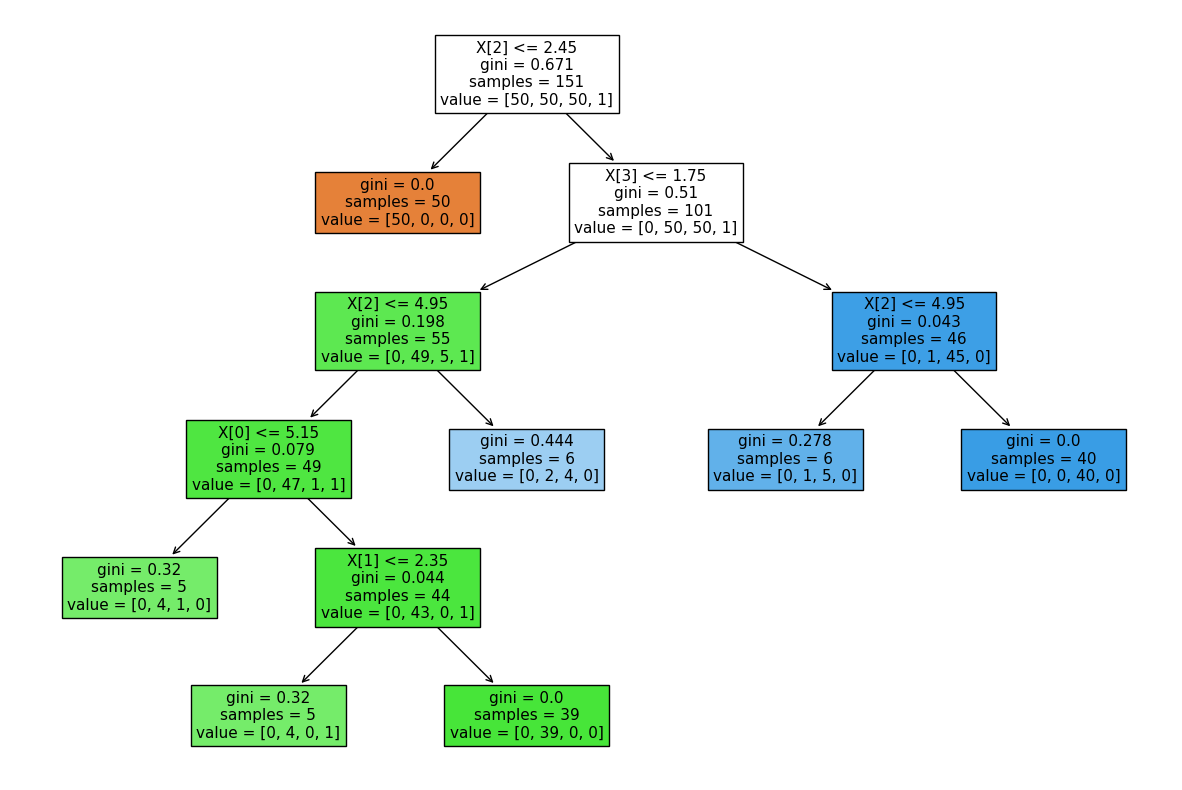

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
# output = plot_tree(safeDTModel.model,filled=True, ax=ax,fontsize=11)

output = plot_tree(safeDTModel, filled=True, ax=ax, fontsize=11)

safeDTModel.save(name="testSave.pkl")
safeDTModel.preliminary_check()
safeDTModel.request_release("testSave.pkl")

## Demonstrate the save and reporting functionality
#### save the model
save(name="testSave.pkl") - Writes model to file in appropriate format (.pkl).
#### perform a preliminary_check 
safeDTModel.preliminary_check() - Checks whether current model parameters violate the safe rules.
Optionally automatically fixes any violations.
#### Request Release
safeDTModel.request_release("testSave.pkl") - Saves model to filename specified and creates a report for the TRE output checkers.

In [14]:
safeDTModel.save(name="testSave.pkl")
safeDTModel.preliminary_check()
safeDTModel.request_release("testSave.pkl")

Preliminary checks: Model parameters are within recommended ranges.



## Now lets try to attack this approach
### starting with listing the params then trying to set the params manually after init

In [15]:
print(safeDTModel.__dict__)

{'model_type': 'DecisionTreeClassifier', 'model': None, 'saved_model': {'model_type': 'DecisionTreeClassifier', 'model': None, 'saved_model': None, 'model_load_file': 'None', 'model_save_file': 'None', 'ignore_items': ['model_save_file', 'basemodel_paramnames', 'ignore_items', 'timestamp'], 'examine_seperately_items': ['tree_'], 'basemodel_paramnames': ['criterion', 'splitter', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'max_features', 'random_state', 'max_leaf_nodes', 'min_impurity_decrease', 'class_weight', 'ccp_alpha'], 'filename': 'None', 'researcher': 'm-albashir', 'timestamp': 'None', 'criterion': 'gini', 'splitter': 'best', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': None, 'max_leaf_nodes': None, 'random_state': None, 'min_impurity_decrease': 0.0, 'class_weight': None, 'ccp_alpha': 0.0, 'k_anonymity': 5, 'n_features_in_': 4, 'n_outputs_': 1, 'classes_': array([0, 1, 2, 4

## Train a model where the min_samples_leaf is 1 
### We extract and plot the decision tree.  
### Because min_samples_leaf is 1 this poses a disclosure risk.
### The prelimanary check reports this.

Training set accuracy in this naive case is 1.0
Preliminary checks: WARNING: model parameters may present a disclosure risk:
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.



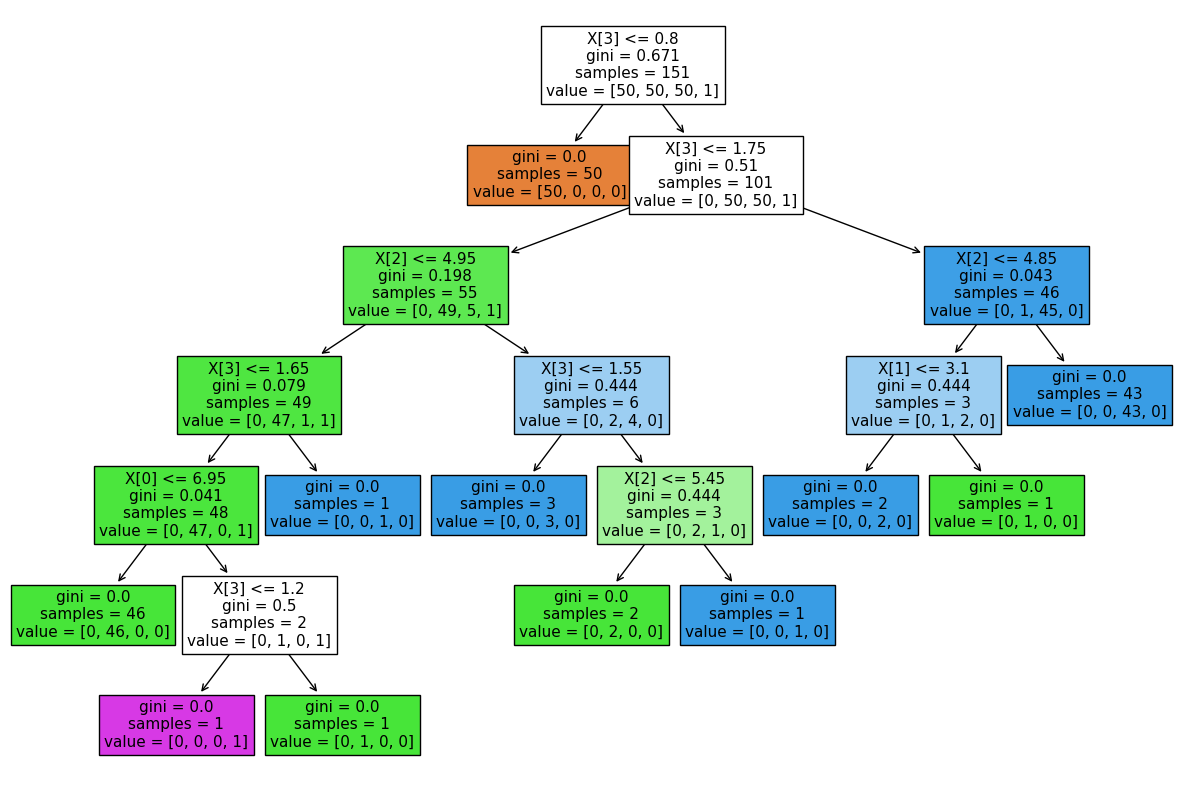

In [16]:
safeDTModel.min_samples_leaf = 1

safeDTModel.fit(X, y)

print(f"Training set accuracy in this naive case is {safeDTModel.score(X,y)}")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(safeDTModel, filled=True, ax=ax, fontsize=11)

safeDTModel.save(name="testSave.pkl")
safeDTModel.preliminary_check()
safeDTModel.request_release("testSave.pkl")

## Example Implemenation runs
### The researcher doesn't change recomended params

In [17]:
# create and fit using recomended params
print("***researcher doesn't change recomended params")
safeDTModel2 = SafeDecisionTreeClassifier()
safeDTModel2.fit(X, y)
safeDTModel2.save(name="safe2.pkl")
safeDTModel2.preliminary_check()
safeDTModel2.posthoc_check()
safeDTModel2.request_release(filename="safe2.pkl")

***researcher doesn't change recomended params
Preliminary checks: WARNING: model parameters may present a disclosure risk:
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Preliminary checks: Model parameters are within recommended ranges.



### The researcher changes params safely

In [18]:
# change model params to recommended values
print("\n***researcher changes params safely")
safeDTModel3 = SafeDecisionTreeClassifier()
safeDTModel3.min_samples_leaf = 5
safeDTModel3.fit(X, y)
safeDTModel3.save(name="safe3.pkl")
safeDTModel3.preliminary_check()
safeDTModel3.posthoc_check()
safeDTModel3.request_release(filename="safe3.pkl")


***researcher changes params safely
Preliminary checks: WARNING: model parameters may present a disclosure risk:
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Preliminary checks: Model parameters are within recommended ranges.



### The researcher changes params safely

In [19]:
# change model params in a safe way
print("\n***researcher changes params safely")
safeDTModel4 = SafeDecisionTreeClassifier()
safeDTModel4.min_samples_leaf = 10
safeDTModel4.fit(X, y)
safeDTModel4.save(name="safe4.pkl")
safeDTModel4.preliminary_check()
safeDTModel4.posthoc_check()
safeDTModel4.request_release(filename="safe4.pkl")


***researcher changes params safely
Preliminary checks: WARNING: model parameters may present a disclosure risk:
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Preliminary checks: Model parameters are within recommended ranges.



### The researcher changes params unsafely

In [20]:
# change model params in an  unsafe way
print("\n***researcher changes params unsafely")
safeDTModel5 = SafeDecisionTreeClassifier()
safeDTModel5.min_samples_leaf = 1
safeDTModel5.save(name="unsafe.pkl")
safeDTModel5.preliminary_check()
safeDTModel5.posthoc_check()
safeDTModel5.request_release(filename="unsafe.pkl")


***researcher changes params unsafely
Preliminary checks: WARNING: model parameters may present a disclosure risk:
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Preliminary checks: WARNING: model parameters may present a disclosure risk:
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Error: user has not called fit() method or has deleted saved values.Recommendation: Do not release.


### The researcher asks for a safe_decision tree but supplies with unsafe params

In [21]:
# ask for a model with unsafe param values
print("\n***researcher asks for a safe_decision tree but supplies with unsafe params")
safeDTModel6 = SafeDecisionTreeClassifier(min_samples_leaf=1)
safeDTModel6.fit(X, y)
safeDTModel6.save(name="fixed-unsafe.pkl")
safeDTModel6.preliminary_check()
safeDTModel6.posthoc_check()
safeDTModel6.request_release(filename="fixed-unsafe.pkl")


***researcher asks for a safe_decision tree but supplies with unsafe params
Preliminary checks: WARNING: model parameters may present a disclosure risk:
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

Preliminary checks: Model parameters are within recommended ranges.



### The researcher asks for a safe_decision tree, changes values to unsafe before fit() then back afterwards

In [22]:
# trains a model with unsafe param values then  hacks values back to safe ones later
print(
    "\n***researcher asks for a safe_decision tree, changes values to unsafe before fit() then back afterwards"
)
safeDTModel7 = SafeDecisionTreeClassifier(min_samples_leaf=1)

safeDTModel7.min_samples_leaf = 1
safeDTModel7.fit(X, y)
print(f"safeDTmodel7.score on training set is {safeDTModel7.score(X,y)}")
print(f"fit called. with min_samples_leaf = {safeDTModel7.min_samples_leaf}")
safeDTModel7.min_samples_leaf = 5


safeDTModel7.save(name="hacked-unsafe.pkl")
msg, disclosive = safeDTModel7.preliminary_check()
print(f"preliminary message is:{msg}")
print(f"preliminary disclosive is:{disclosive}")
msg2, disclosive2 = safeDTModel7.posthoc_check()
print(f"posthoc message is:{msg2}")
print(f"posthoc disclosive is:{disclosive2}")
safeDTModel7.request_release(filename="hacked-unsafe.pkl")


***researcher asks for a safe_decision tree, changes values to unsafe before fit() then back afterwards
Preliminary checks: WARNING: model parameters may present a disclosure risk:
- parameter min_samples_leaf = 1 identified as less than the recommended min value of 5.
Changed parameter min_samples_leaf = 5.

safeDTmodel7.score on training set is 1.0
fit called. with min_samples_leaf = 1
Preliminary checks: Model parameters are within recommended ranges.

preliminary message is:Model parameters are within recommended ranges.

preliminary disclosive is:False
posthoc message is:Warning: basic parameters differ in 1 places:
parameter min_samples_leaf changed from 1 to 5 after model was fitted.

posthoc disclosive is:True
parameter min_samples_leaf changed from 1 to 5 after model was fitted.



## Examine the contents of the checkfile.
### The checkfile is written in JSON format

In [23]:
!echo "contents of checkfile are"; cat *_checkfile.json

"contents of checkfile are"; cat *_checkfile.json
